In [1]:
#import packages needed
#pip install scikit-image
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#Define the 2 paths for pedestrian images
#dataset - http://www.lookingatpeople.com/download-daimler-ped-class-benchmark/index.html
pedestrian="./ped"
non_pedestrian="./non-ped"

In [3]:
#preview images with a function
def preview_images(folder_path, label_name, n=5):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.pgm')]
    sample_files = random.sample(image_files, min(n, len(image_files)))

    plt.figure(figsize=(15, 3))
    for i, filename in enumerate(sample_files):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{label_name}\n{filename}\n{img.shape}")
        plt.axis('off')
    plt.suptitle(f"Preview of {label_name} Images")
    plt.tight_layout()
    plt.show()

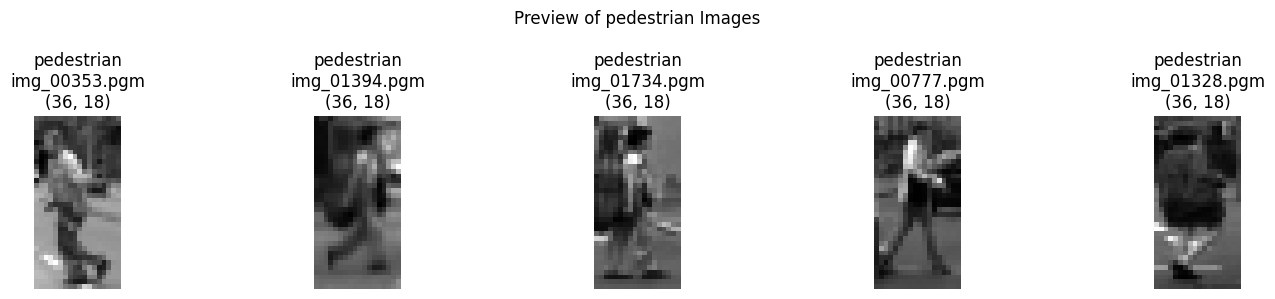

In [4]:
#pedestrian sample
preview_images(pedestrian,'pedestrian')

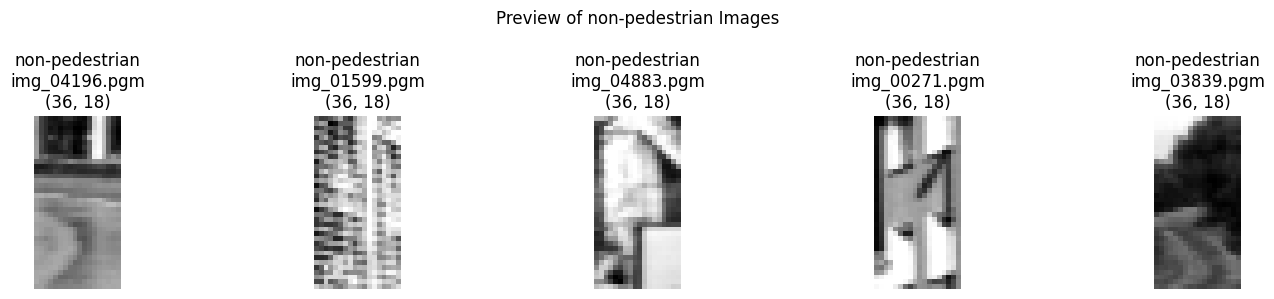

In [5]:
#non-pedrestrian sample
preview_images(non_pedestrian,'non-pedestrian')

In [6]:
#Here we define needed functions 
def load_images(folder_path, label):
    data, labels = [], []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.pgm', '.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, image_size)
            features = hog(img, **hog)
            data.append(features)
            labels.append(label)
    return data, labels




In [ ]:
#Here we define our main training pipeline
#Initial parameters
#For HOG parameters, we use this numbers based on scikit learn documentation and https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf
def main():
    # Config
    image_size = (18, 36)
    hog_p = {
        'orientations': 9,
        'pixels_per_cell': (6, 6),
        'cells_per_block': (2, 2),
        'block_norm': 'L2-Hys'
    }

    # 1. Load images and labels
    def load_images_from_folder(folder_path, label):
        data = []
        labels = []
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.pgm')):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, image_size)
                features = hog(img, **hog_p)
                data.append(features)
                labels.append(label)
        return data, labels

    pedestrian="./ped"
    non_pedestrian="./non-ped"

    ped_data, ped_labels = load_images_from_folder(pedestrian, 1)
    nonped_data, nonped_labels = load_images_from_folder(non_pedestrian, 0)

    X = np.array(ped_data + nonped_data)
    y = np.array(ped_labels + nonped_labels)

    # 2. Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 3. Train SVM
    svm = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    print("Initial Evaluation:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # 4. Grid Search
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.001],
        'kernel': ['rbf', 'linear']
    }

    grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=1,n_jobs=-1)
    #Here - be cautios as cv 5 with 3 options in C and 2 options in gamma and 2 options in kernel will result in:
    # 3 X 2 X 2 = 18 combinations
    # 18 x 5 (numbers that test dataset is splited)=90 fits or potential adjustments 
    grid.fit(X_train, y_train)


    print("\nBest Parameters:")
    print(grid.best_params_)

    # 5. Final Evaluation
    best_model = grid.best_estimator_
    final_pred = best_model.predict(X_test)

    print("\nFinal Eval:")
    print(confusion_matrix(y_test, final_pred))
    print(classification_report(y_test, final_pred))

    # 6. Plot Confusion Matrix
    cm = confusion_matrix(y_test, final_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Non-Ped", "Ped"], yticklabels=["Non-Ped", "Ped"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()



Initial Evaluation:
[[954  46]
 [ 16 944]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1000
           1       0.95      0.98      0.97       960

    accuracy                           0.97      1960
   macro avg       0.97      0.97      0.97      1960
weighted avg       0.97      0.97      0.97      1960

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Parameters:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Final Eval:
[[963  37]
 [ 17 943]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1000
           1       0.96      0.98      0.97       960

    accuracy                           0.97      1960
   macro avg       0.97      0.97      0.97      1960
weighted avg       0.97      0.97      0.97      1960



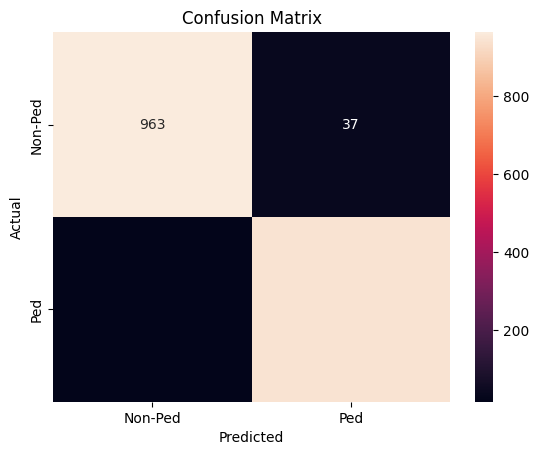

In [8]:
#Here we execute the full pipeline
main()

In [9]:
cm = confusion_matrix(y_test, final_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Ped", "Ped"], yticklabels=["Non-Ped", "Ped"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'y_test' is not defined